# TEST DATA SCIENTIST
#### Author: Martin BRICENO

In [133]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import fbeta_score
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
import seaborn as sns

In [134]:
def score_classifier(dataset,classifier,labels):

    """
    performs 3 random trainings/tests to build a confusion matrix and prints results with precision and recall scores
    :param dataset: the dataset to work on
    :param classifier: the classifier to use
    :param labels: the labels used for training and validation
    :return:
    """

    kf = KFold(n_splits=3,random_state=50,shuffle=True)
    confusion_mat = np.zeros((2,2))
    recall = 0
    precision = 0
    fbeta = 0
    for training_ids,test_ids in kf.split(dataset):
        training_set = dataset[training_ids]
        training_labels = labels[training_ids]
        test_set = dataset[test_ids]
        test_labels = labels[test_ids]
        classifier.fit(training_set,training_labels)
        predicted_labels = classifier.predict(test_set)
        confusion_mat+=confusion_matrix(test_labels,predicted_labels)
        recall += recall_score(test_labels, predicted_labels)
        precision += precision_score(test_labels, predicted_labels)
        fbeta += fbeta_score(test_labels, predicted_labels, average='binary', beta=0.5)
    recall/=3
    precision/=3
    fbeta/=3
    print("Conf matrix=\n",confusion_mat)
    print("Recall=",recall)
    print("Precision=",precision)
    print("fbeta_score=",fbeta)
    return classifier,confusion_mat

> J'ai modifié la fonction de score car le "recall" tout seul n'est pas une bonne métrique pour mesurer la performance d'un classifieur. Comme je le montrerai plus tard, un mauvais classificateur qui prédit que tous les joueurs vont durer plus de 5 ans aura un "recall" de 1 mais une faible "précision". Cela serait très préjudiciable aux investisseurs, car ce classificateur vous dirait que vous pouvez investir dans n'importe qui.

> Les investisseurs craignent surtout d'investir dans les mauvaises personnes, car cela leur fera perdre de l'argent à long terme. Notre modèle doit donc être très confiant dans le fait que les joueurs qu'il prédit positivement dureront effectivement plus de 5 ans. Cela se mesure par la précision.

> Cependant, si l'on considère uniquement la précision, notre modèle exclura de nombreux joueurs qui dureront effectivement plus de 5 ans, en échange de la certitude que ses prédictions sont sûres. Ce n'est pas bon car plus l'investisseur a d'options, plus il peut prendre de meilleures décisions et donc constituer de meilleures équipes qui généreront plus de bénéfices.

> C'est pourquoi j'ai l'intention d'utiliser une métrique qui prend en compte les deux mesures ( recall, précision) mais qui considère la précision comme plus importante. Très similaire au score F1, il est appelé Fbeta-score, où la valeur bêta définit la relevance donnée à chaque mesure. Dans notre cas, je vais fixer cette valeur à 0,5 pour indiquer que la précision est 2 fois plus importante que le rappel. Ce paramètre dépend du besoin de l'investisseur et peut être modifié.

# Loading Data

In [135]:
# Load dataset
df = pd.read_csv(".\\nba_logreg.csv")
df

,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,...,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0.0
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,...,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0.0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,...,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0.0
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,...,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1.0
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,...,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1335,Chris Smith,80,15.8,4.3,1.6,3.6,43.3,0.0,0.2,14.3,...,1.5,79.2,0.4,0.8,1.2,2.5,0.6,0.2,0.8,0.0
1336,Brent Price,68,12.6,3.9,1.5,4.1,35.8,0.1,0.7,16.7,...,1.0,79.4,0.4,1.1,1.5,2.3,0.8,0.0,1.3,1.0
1337,Marlon Maxey,43,12.1,5.4,2.2,3.9,55.0,0.0,0.0,0.0,...,1.6,64.3,1.5,2.3,3.8,0.3,0.3,0.4,0.9,0.0
1338,Litterial Green,52,12.0,4.5,1.7,3.8,43.9,0.0,0.2,10.0,...,1.8,62.5,0.2,0.4,0.7,2.2,0.4,0.1,0.8,1.0


# Pre-processing

## Data types

In [136]:
# Types and non null features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         1340 non-null   object 
 1   GP           1340 non-null   int64  
 2   MIN          1340 non-null   float64
 3   PTS          1340 non-null   float64
 4   FGM          1340 non-null   float64
 5   FGA          1340 non-null   float64
 6   FG%          1340 non-null   float64
 7   3P Made      1340 non-null   float64
 8   3PA          1340 non-null   float64
 9   3P%          1329 non-null   float64
 10  FTM          1340 non-null   float64
 11  FTA          1340 non-null   float64
 12  FT%          1340 non-null   float64
 13  OREB         1340 non-null   float64
 14  DREB         1340 non-null   float64
 15  REB          1340 non-null   float64
 16  AST          1340 non-null   float64
 17  STL          1340 non-null   float64
 18  BLK          1340 non-null   float64
 19  TOV   

> On voit qu'on a pas des features catégoriques mais il y a des valeurs manquantes

## Missing Data

In [137]:
# In wich columns we find missing values
df.columns[df.isna().sum()!=0].tolist()

['3P%']

In [138]:
# show the columns with missing data to analyse it
df[df["3P%"].isna()]

,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
338,Ken Johnson,64,12.7,4.1,1.8,3.3,52.8,0.0,0.0,NaN,...,1.3,43.5,1.4,2.4,3.8,0.3,0.2,0.3,0.9,0.0
339,Ken Johnson,64,12.7,4.1,1.8,3.3,52.8,0.0,0.0,NaN,...,1.3,43.5,1.4,2.4,3.8,0.3,0.2,0.3,0.9,0.0
340,Pete Williams,53,10.8,2.8,1.3,2.1,60.4,0.0,0.0,NaN,...,0.8,42.5,0.9,1.9,2.8,0.3,0.4,0.4,0.4,0.0
358,Melvin Turpin,79,24.7,10.6,4.6,9.0,51.1,0.0,0.0,NaN,...,1.8,78.4,2.0,3.8,5.7,0.5,0.5,1.1,1.5,1.0
386,Jim Petersen,60,11.9,3.2,1.2,2.4,48.6,0.0,0.0,NaN,...,1.1,75.8,0.7,1.7,2.5,0.5,0.2,0.5,1.2,1.0
397,Tom Scheffler,39,6.9,1.3,0.5,1.3,41.2,0.0,0.0,NaN,...,0.5,50.0,0.5,1.5,1.9,0.3,0.2,0.3,0.4,0.0
507,Sam Williams,59,18.2,6.1,2.6,4.7,55.6,0.0,0.0,NaN,...,1.5,55.1,1.5,3.7,5.2,0.6,0.8,1.3,1.1,0.0
509,Kurt Nimphius,63,17.2,5.3,2.2,4.7,46.1,0.0,0.0,NaN,...,1.7,58.3,1.5,3.2,4.7,1.0,0.3,1.3,0.9,1.0
510,Pete Verhoeven,71,17.0,4.9,2.1,4.2,50.3,0.0,0.0,NaN,...,1.0,70.8,1.5,2.1,3.6,0.7,0.6,0.3,0.8,1.0
521,Jim Smith,72,11.9,2.9,1.2,2.3,50.9,0.0,0.0,NaN,...,1.2,45.9,1.0,1.5,2.5,0.6,0.3,0.7,0.7,0.0


In [139]:
# replacing Nan values (only present when no 3 points attempts have been performed by a player)
# for x in np.argwhere(np.isnan(df_vals)):
#     df_vals[x]=0.0
df["3P%"]=df["3P%"].fillna(0.0)

> La seule colonne avec des valeurs manquantes est "3P%", il y a seulement 11 valeurs manquantes. J'ai rempli ces valeurs avec 0 et non avec la moyenne puisque celle-ci est liée à la colonne "3PA", si celle-ci est nulle, alors "3P%" aussi.

> Ici j'ai remarqué que les deux premières lignes correspondent aux paramètres de la même personne "Ken Johnson", il y a des doublons dans nos données!. J'ai donc fait une analyse pour voir s'il y a beaucoup de lignes répétées et surtout pour savoir si leurs valeurs de "TARGET_5Yrs" n'avaient pas été modifiées.

## Inconsistent  data

In [140]:
# There are repeated names, we find how many times they appear 
print(df.groupby("Name").count()["GP"][df.groupby("Name").count()["GP"]>1])
print("total=",df.groupby("Name").count()["GP"][df.groupby("Name").count()["GP"]>1].sum())

Name
Bob Martin          2
Bobby Jones         2
Carlos Rogers       2
Cedric Henderson    2
Charles Jones       6
Charles Smith       9
Chris Smith         2
Cory Alexander      2
David Lee           2
Dee Brown           4
Eddie Johnson       2
Gerald Henderson    2
Glen Rice           2
Glenn Robinson      2
James Johnson       2
Jamie Feick         2
Jeff Taylor         2
Ken Johnson         2
Larry Drew          2
Larry Johnson       2
Marcus Williams     2
Mark Bryant         2
Mark Davis          4
Michael Anderson    2
Michael Smith       4
Mike Dunleavy       2
Reggie Williams     2
Tim Hardaway        2
Walker Russell      2
Name: GP, dtype: int64
total= 75


In [141]:
# Those are the conflicted names because they appear more than one time
conflict_names=df.groupby("Name").count()["GP"][df.groupby("Name").count()["GP"]>1].index
conflict_names

Index(['Bob Martin', 'Bobby Jones', 'Carlos Rogers', 'Cedric Henderson',
       'Charles Jones', 'Charles Smith', 'Chris Smith', 'Cory Alexander',
       'David Lee', 'Dee Brown', 'Eddie Johnson', 'Gerald Henderson',
       'Glen Rice', 'Glenn Robinson', 'James Johnson', 'Jamie Feick',
       'Jeff Taylor', 'Ken Johnson', 'Larry Drew', 'Larry Johnson',
       'Marcus Williams', 'Mark Bryant', 'Mark Davis', 'Michael Anderson',
       'Michael Smith', 'Mike Dunleavy', 'Reggie Williams', 'Tim Hardaway',
       'Walker Russell'],
      dtype='object', name='Name')

In [142]:
# Now we see if they have the same features and the same target
supp_lines = 0
for name in conflict_names:
    group = df[df["Name"]==name].groupby(df.columns[:-1].tolist()).mean()
    if(any([target not in [1.0, 0.0] for target in group["TARGET_5Yrs"].tolist()])):
        print(group)
        idx = df[df["Name"]==name].index.tolist()
        df.drop(idx,axis=0,inplace=True)
        supp_lines += len(idx)
print("Erased_lines=",supp_lines)

                                                                                                 TARGET_5Yrs
Name        GP MIN PTS FGM FGA FG%  3P Made 3PA 3P%  FTM FTA FT%  OREB DREB REB AST STL BLK TOV             
Bobby Jones 44 7.6 2.5 1.0 2.1 46.2 0.0     0.2 11.1 0.5 0.9 56.1 0.5  0.8  1.3 0.4 0.3 0.0 0.4          0.5
                                                                                                       TARGET_5Yrs
Name             GP MIN  PTS  FGM FGA FG%  3P Made 3PA 3P% FTM FTA FT%  OREB DREB REB AST STL BLK TOV             
Cedric Henderson 82 30.8 10.1 4.2 8.8 48.0 0.0     0.0 0.0 1.7 2.3 71.6 0.9  3.1  4.0 2.0 1.2 0.6 2.0          0.5
                                                                                                    TARGET_5Yrs
Name          GP MIN  PTS FGM FGA FG%  3P Made 3PA 3P%  FTM FTA FT%  OREB DREB REB AST STL BLK TOV             
Charles Jones 29 16.4 3.7 1.3 4.2 31.7 0.7     2.1 31.1 0.4 0.8 50.0 0.3  1.1  1.4 1.4 0.6 0.2 1.0     0

> Nous avons vérifié que 75 lignes avaient des noms répétés, ce qui pourrait ne pas être un problème, cependant, dans cet ensemble 45 d'entre elles étaient incohérentes, ce qui signifie que deux lignes avec les mêmes paramètres ("GP", "MIN",..) avaient, l'une TARGET_5Yrs=1 et l'autre TARGET_5Yrs=0. 

> C'est mauvais pour l'entraînement', car notre modèle ne sera pas en mesure d'apprendre correctement à partir des caractéristiques. J'ai donc effectué un traitement pour les supprimer de l'ensemble de données car ils n'étaient pas nombreux.

## Outliers

In [143]:
# Using the Inter Quantile Range method (IQR) to retrieve the outliers
Q1 = df.loc[:,"GP":"TOV"].quantile(0.25)
Q3 = df.loc[:,"GP":"TOV"].quantile(0.75)
IQR = Q3-Q1
lower_bound = Q1-1.5*IQR
upper_bound = Q3+1.5*IQR

In [144]:
for col in df.columns[1:-1].tolist():
    lower_points= (df[col]<lower_bound[col]).sum()
    upper_points= (df[col]>upper_bound[col]).sum()
    print(f"{col}: nb_lower_points={lower_points}, nb_upper_points={upper_points}")

GP: nb_lower_points=0, nb_upper_points=0
MIN: nb_lower_points=0, nb_upper_points=1
PTS: nb_lower_points=0, nb_upper_points=54
FGM: nb_lower_points=0, nb_upper_points=48
FGA: nb_lower_points=0, nb_upper_points=57
FG%: nb_lower_points=5, nb_upper_points=13
3P Made: nb_lower_points=0, nb_upper_points=69
3PA: nb_lower_points=0, nb_upper_points=66
3P%: nb_lower_points=0, nb_upper_points=4
FTM: nb_lower_points=0, nb_upper_points=67
FTA: nb_lower_points=0, nb_upper_points=69
FT%: nb_lower_points=31, nb_upper_points=5
OREB: nb_lower_points=0, nb_upper_points=37
DREB: nb_lower_points=0, nb_upper_points=51
REB: nb_lower_points=0, nb_upper_points=50
AST: nb_lower_points=0, nb_upper_points=79
STL: nb_lower_points=0, nb_upper_points=55
BLK: nb_lower_points=0, nb_upper_points=72
TOV: nb_lower_points=0, nb_upper_points=63


In [145]:
for col in df.columns[1:-1].tolist():
    df[col][df[col]<lower_bound[col]]=lower_bound[col]
    df[col][df[col]>upper_bound[col]]=upper_bound[col]

<ipython-input-145-d50a10693a54>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][df[col]<lower_bound[col]]=lower_bound[col]
<ipython-input-145-d50a10693a54>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][df[col]>upper_bound[col]]=upper_bound[col]


> J'ai également effectué une analyse des valeurs aberrantes afin que celles-ci n'affectent pas la prédiction. Dans chaque colonne, ils étaient au-dessus de la borne supérieure et n'étaient pas nombreux, je les ai donc tronqués pour garder l'information qu'il s'agissait de valeurs élevées.J'ai également effectué une analyse des valeurs aberrantes afin que celles-ci n'affectent pas la prédiction. Dans chaque colonne, ils étaient au-dessus de la borne supérieure et n'étaient pas nombreux, je les ai donc tronqués pour garder l'information qu'il s'agissait de valeurs élevées.

## Normalize and standardize

In [146]:
# Stat view
df.describe()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
count,1295.000000,1295.000000,1295.000000,1295.000000,1295.000000,1295.000000,1295.000000,1295.000000,1295.000000,1295.000000,1295.000000,1295.000000,1295.000000,1295.000000,1295.000000,1295.000000,1295.000000,1295.000000,1295.000000,1295.000000
mean,60.303475,17.568456,6.639151,2.569653,5.764788,44.122780,0.227722,0.735598,19.238764,1.229112,1.738687,70.495135,0.989035,1.973282,2.956757,1.433127,0.602432,0.336602,1.159151,0.623938
std,17.401872,8.234011,3.926832,1.526722,3.281039,5.958307,0.317076,0.920524,15.886396,0.789984,1.088287,9.956749,0.711402,1.205556,1.826196,1.136764,0.372364,0.315794,0.643484,0.484583
min,11.000000,3.100000,0.700000,0.300000,0.800000,28.800000,0.000000,0.000000,0.000000,0.000000,0.000000,45.625000,0.000000,0.200000,0.300000,0.000000,0.000000,0.000000,0.100000,0.000000
25%,47.000000,10.900000,3.700000,1.400000,3.300000,40.200000,0.000000,0.000000,0.000000,0.600000,0.900000,64.750000,0.400000,1.000000,1.500000,0.600000,0.300000,0.100000,0.700000,0.000000
50%,63.000000,16.100000,5.600000,2.100000,4.800000,43.900000,0.100000,0.300000,22.200000,1.000000,1.500000,71.200000,0.800000,1.700000,2.500000,1.100000,0.500000,0.200000,1.000000,1.000000
75%,77.000000,22.800000,8.800000,3.400000,7.500000,47.800000,0.400000,1.200000,32.750000,1.600000,2.300000,77.500000,1.400000,2.600000,3.900000,2.000000,0.800000,0.500000,1.500000,1.000000
max,82.000000,40.650000,16.450000,6.400000,13.800000,59.200000,1.000000,3.000000,81.875000,3.100000,4.400000,96.625000,2.900000,5.000000,7.500000,4.100000,1.550000,1.100000,2.700000,1.000000


In [147]:
# extract names, labels, features names and values
names = df['Name'].values.tolist() # players names
labels = df['TARGET_5Yrs'].values # labels
paramset = df.drop(['TARGET_5Yrs','Name'],axis=1).columns.values
df_vals = df.drop(['TARGET_5Yrs','Name'],axis=1).values

In [148]:
# normalize and standardize dataset
X = MinMaxScaler().fit_transform(df_vals)
X = StandardScaler().fit_transform(X)

> Étant donné que certaines colonnes comme "GP" ont des valeurs moyennes très élevées par rapport à d'autres "3PA", il est nécessaire de mettre les données à l'échelle et de les normaliser afin que cela n'influence pas la prédiction.

> On remarque également que la moyenne de la colonne "TARGET_5Yrs" est de 0,62, cela indique que les données sont déséquilibrées.

## Balancing data

Data size = 1295


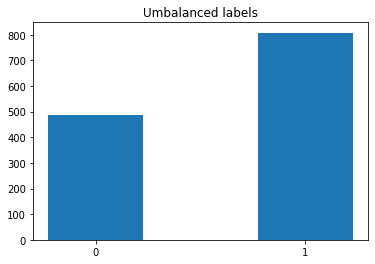

In [149]:
# Plot number of labels by class
print("Data size =",len(X))
plt.figure()
dict_count_labels = Counter(labels)
plt.bar(["0","1"],dict_count_labels.values(),width=0.45)
plt.title("Umbalanced labels")
plt.show()

In [150]:
# Oversample the minority class
ros = RandomOverSampler(random_state=42)
X, labels = ros.fit_resample(X, labels)

Data size = 1616


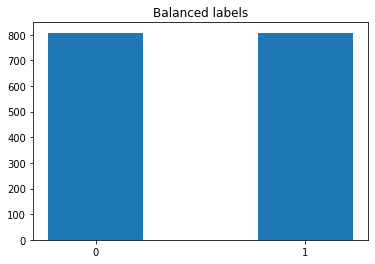

In [151]:
# Plot number of labels by class
print("Data size =",len(X))
plt.figure()
dict_count_labels = Counter(labels)
plt.bar(["0","1"],dict_count_labels.values(),width=0.45)
plt.title("Balanced labels")
plt.show()

> En comptant les étiquettes de chaque classe, j'ai remarqué que la classe 0 est minoritaire dans un rapport de 5 à 8 avec la classe 1.

> Ce n'est pas bon étant donné qu'un qualificateur naïf qui qualifierait un joueur de notre jeu avec la classe majoritaire, posséderait déjà une précision d'environ 61,5%, ce qui est supérieur à 50%. Par conséquent, même s'il n'a rien appris des caractéristiques, il peut être considéré comme un bon modèle.

> Pour cette raison, j'ai effectué un traitement de suréchantillonnage afin de créer plus de données provenant de la classe minoritaire, ce qui permettra de résoudre le problème de déséquilibre et on aura également plus de données.

# Analysis

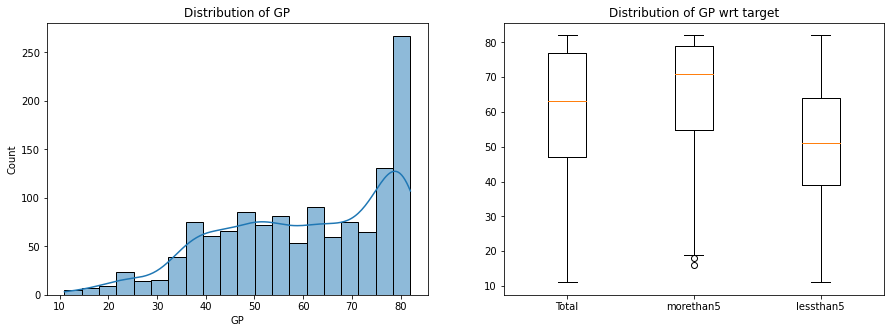

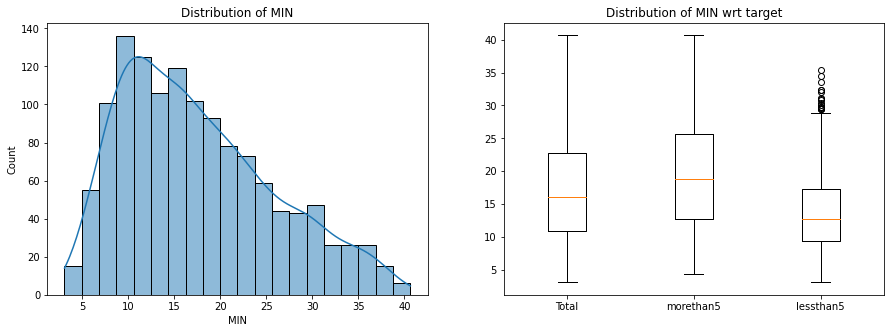

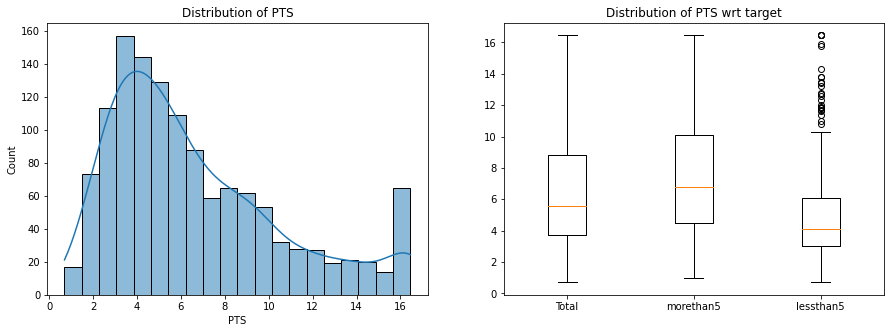

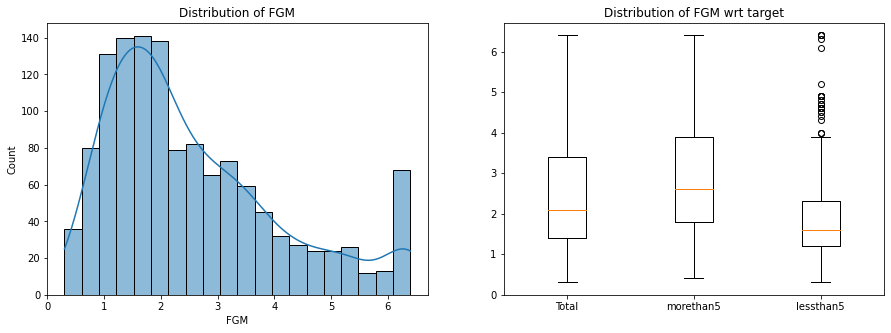

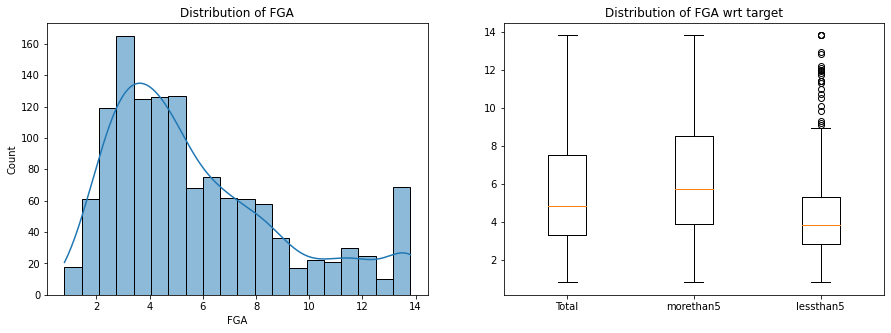

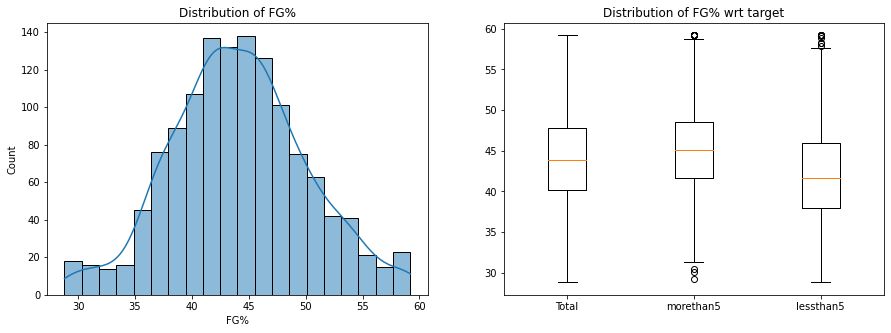

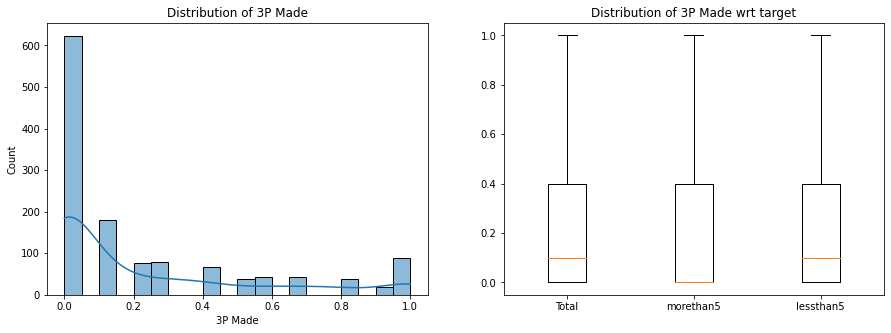

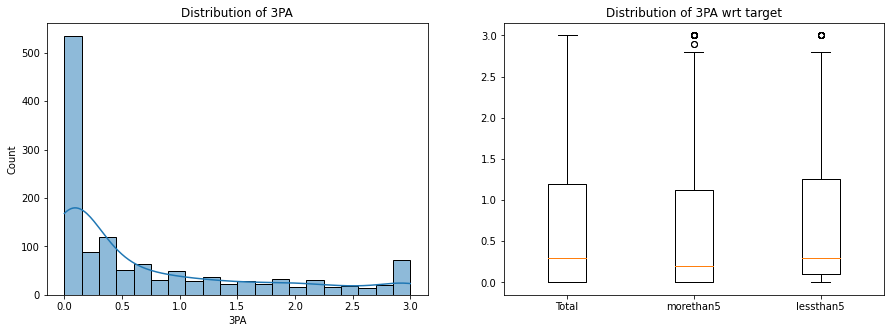

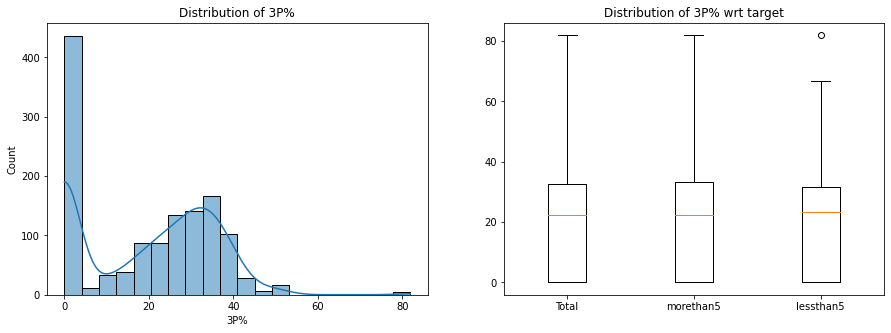

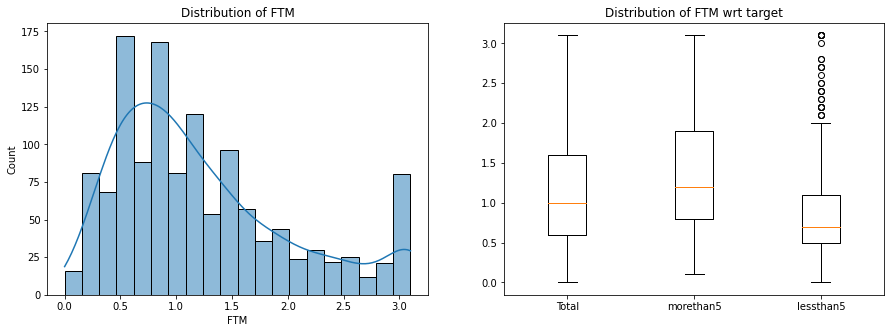

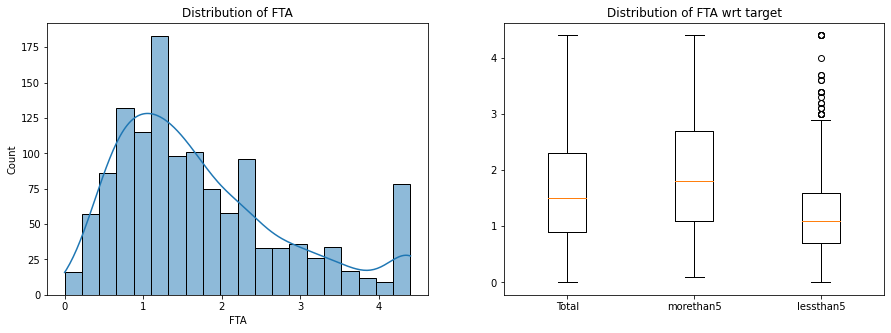

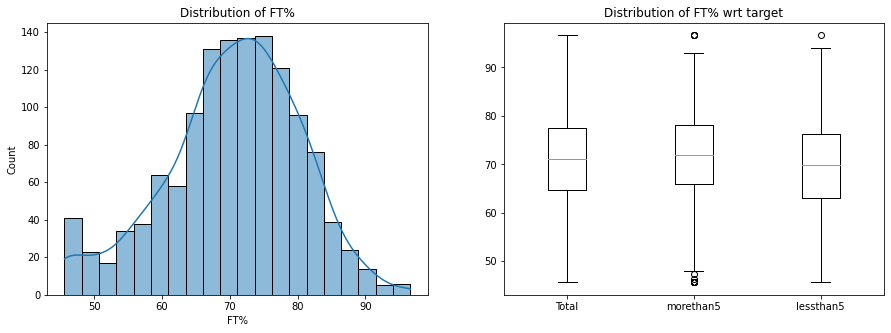

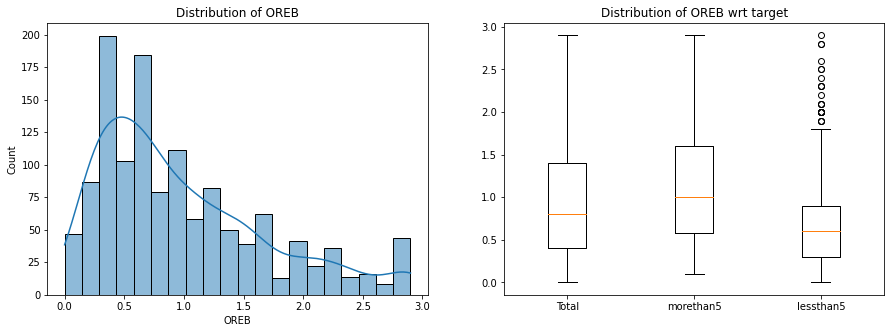

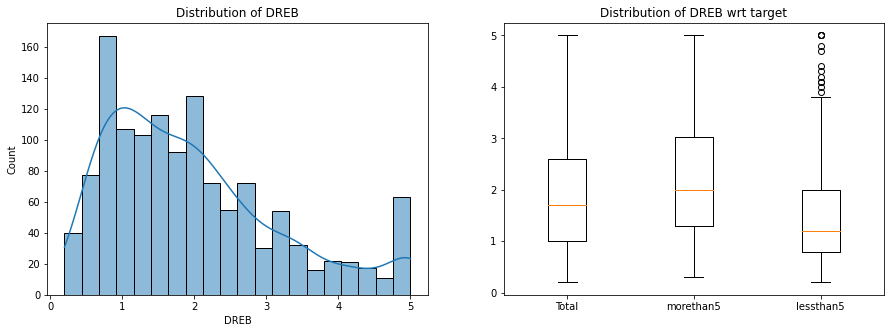

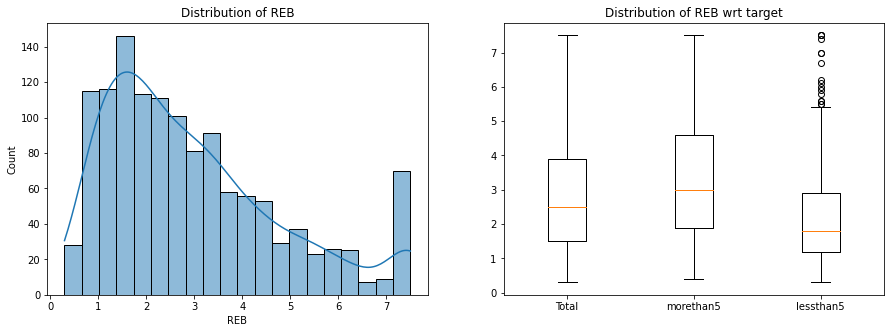

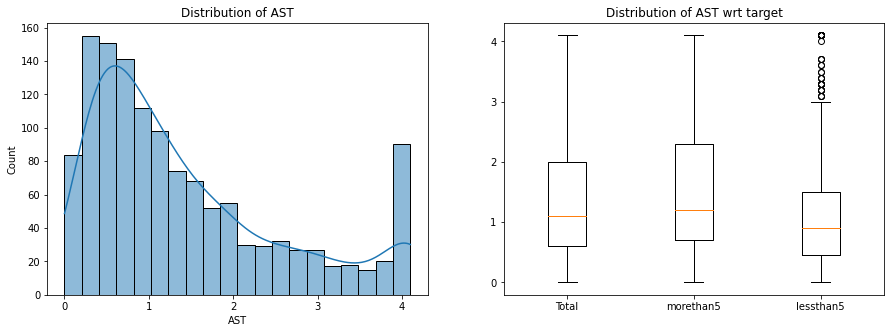

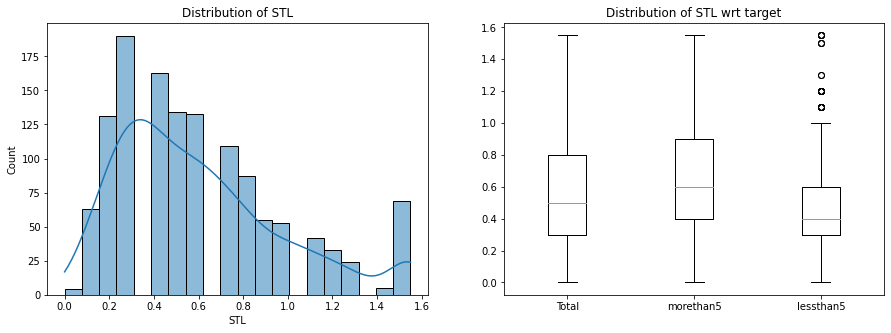

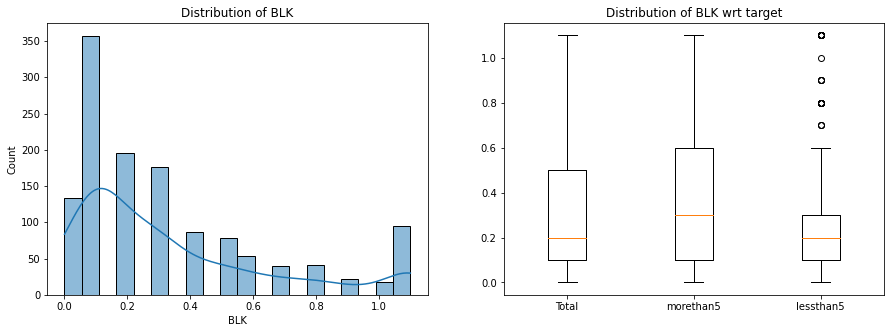

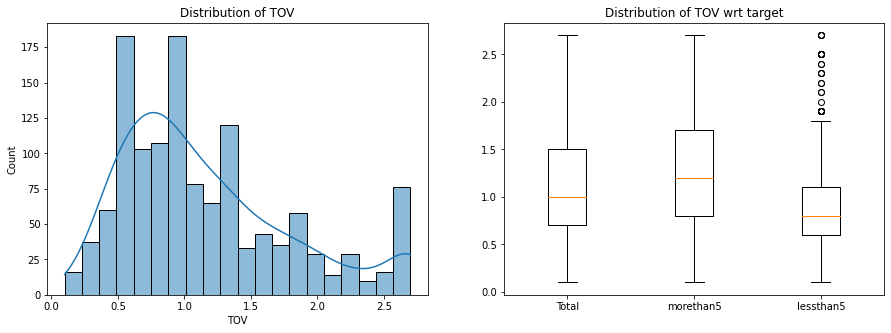

In [152]:
# Distribution of columns
for col in df.columns[1:-1].tolist():
    gameplayed=df[col]
    f, ax = plt.subplots(1, 2, figsize=(15, 5))
    sns.histplot(gameplayed,bins=20,kde=True,ax=ax[0])
    ax[0].set_title(f"Distribution of {col}")

    total = df[col].tolist()
    morethan5 = df[df['TARGET_5Yrs'] == 1][col].tolist()
    lessthan5 = df[df['TARGET_5Yrs'] == 0][col].tolist()
    x_labels = ["Total", "morethan5", "lessthan5"]
    ax[1].boxplot([total, morethan5, lessthan5])
    ax[1].set_title(f"Distribution of {col} wrt target")
    plt.xticks(list(range(1,len(x_labels)+1)), x_labels)
    plt.show()

> D'après la distribution des GP, nous constatons qu'un pourcentage élevé d'entre eux ont joué environ 80 parties. En analysant celles qui ont duré plus de 5 ans et celles qui n'ont pas duré, on constate que la médiane des premières est supérieure à celle des secondes. Cela pourrait impliquer que le fait de jouer à plus de jeux est une caractéristique importante pour durer plus de 5 ans.

> Presque le même phénomène se produit pour le reste des caractéristiques, à l'exception de "3PA", "3P%" et "3P Made" où les graphiques montrent peu de relation entre ces caractéristiques et le target, la taille de chaque box et les médianes sont très similaires quelle que soit leur étiquette.

# Classifiers

In [153]:
#example of scoring with support vector classifier
clf,cm=score_classifier(X,SVC(),labels)

Conf matrix=
 [[610. 198.]
 [269. 539.]]
Recall= 0.6692058103018833
Precision= 0.7324953303676086
fbeta_score= 0.7174172119134613


In [155]:
clf,cm=score_classifier(X,DummyClassifier(strategy="constant",constant=1),labels)

Conf matrix=
 [[  0. 808.]
 [  0. 808.]]
Recall= 1.0
Precision= 0.49998965453028116
fbeta_score= 0.5554740385296176


> C'est le classificateur dont j'ai parlé au début, il classe toutes les données comme 1 (joueurs qui dureront plus de 5 ans) et par conséquent nous voyons que son recall est 1 mais sa précision est faible puisqu'il a correctement classé les 808 étiquettes positives mais les 808 autres qui étaient négatives, il les a également prédites comme positives. Même son fbeta_score est le plus bas de tous les modèles présentés ici.

In [156]:
clf,cm=score_classifier(X,LogisticRegression(),labels)

Conf matrix=
 [[588. 220.]
 [261. 547.]]
Recall= 0.6780276804778437
Precision= 0.7146605988087602
fbeta_score= 0.7062609572763335


In [157]:
clf,cm=score_classifier(X,XGBClassifier(booster="gblinear",use_label_encoder=False,learning_rate=0.01,eval_metric="error",scale_pos_weight=0.2),labels)


Conf matrix=
 [[759.  49.]
 [540. 268.]]
Recall= 0.3324184005429422
Precision= 0.8454047389088927
fbeta_score= 0.6443532285709058


> D'autre part, nous avons le classificateur qui nous donne une grande précision mais à condition d'avoir un faible recall, c'est-à-dire que ce classificateur est très confiant dans ses prédictions (TP=268) mais a mal prédit la plupart des joueurs qui vont vraiment durer plus de 5 ans en les classant comme négatifs (FN=540).

In [162]:
# # TODO build a training set and choose a classifier which maximize recall score returned by the score_classifier function
clf,cm=score_classifier(X,RandomForestClassifier(),labels)

Conf matrix=
 [[665. 143.]
 [218. 590.]]
Recall= 0.7319427278057854
Precision= 0.8059249343187926
fbeta_score= 0.7888393282154867


> Finalement, nous avons un bon modèle, il a une bonne précision, proche de 80%, mais en même temps il a un recall élevé d'environ 72%. Nous remarquons que le TP=584 dans ce cas est plus élevé que le FN=224 contrairement au modèle précédent. 

> Ce modèle nous dit qu'il a une probabilité de 80% d'être sûr de sa prédiction tout en nous donnant une grande liberté de choisir notre joueur puisqu'il a trouvé 72% de ceux qui dureront effectivement plus de 5 ans.


# Best Model

Conf matrix=
 [[670. 138.]
 [218. 590.]]
Recall= 0.7315985168241985
Precision= 0.8106746098495469
fbeta_score= 0.7929191170363272


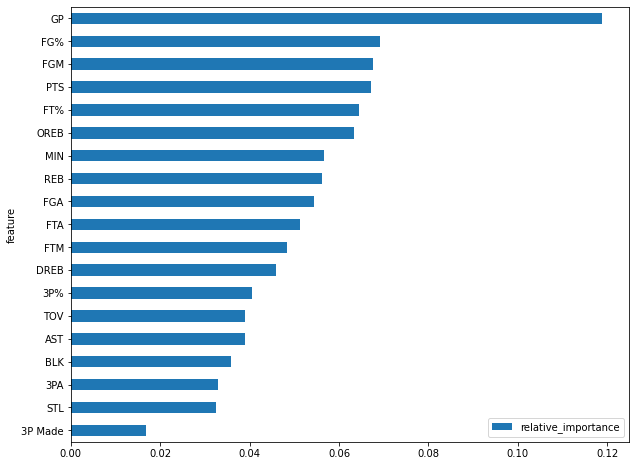

In [160]:
# Show the importance of each feature to do the prediction
clf,cm=score_classifier(X,RandomForestClassifier(),labels)

feature_imp=pd.DataFrame()
for feature,imp in zip(df.columns[1:-1],clf.feature_importances_):
    temp=pd.DataFrame([feature,imp]).T
    feature_imp=feature_imp.append(temp)
feature_imp.columns=['feature','relative_importance']
feature_imp.sort_values(by='relative_importance',inplace=True)
feature_imp.set_index('feature',inplace=True)
feature_imp.plot(kind='barh',figsize=(10,8))
plt.show()

> En analysant l'importance de chaque caractéristique dans la prédiction, nous constatons que la caractéristique la plus importante est le "GP", suivi du "FG%" et du "FGM", et la moins importante est le "3P Made".

> Ceci est logique puisque lorsque nous avons fait l'analyse, nous avons vu que le "GP" des joueurs ayant plus de 5 ans était plus élevé que celui des joueurs n'ayant pas plus de 5 ans, ce qui montre une relation entre le "GP" et "TARGET_5Yrs", cependant le "3P made" n'avait pas beaucoup de données significatives et ne variait pas beaucoup pour chaque classe.

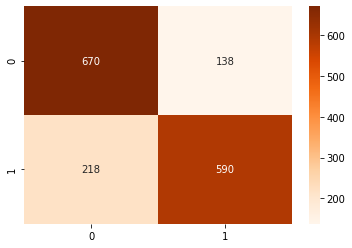

In [161]:
# Plot confusion matrix
sns.heatmap(cm.astype(np.int32), annot=True,
            cmap='Oranges',fmt="d")
_ = plt.ylim(2, 0)

> La matrice de confusion montre que notre modèle est performant pour trouver les vraies valeurs de chaque classe. Il est intéressant de noter qu'il est meilleur pour prédire dans qui nous ne devrions pas investir, ce qui n'est pas l'objectif de notre analyse mais est utile car nous avons plus de chances de ne pas investir de manière incorrecte.

# Deploiement

> Le déploiement a été effectué en utilisant  FastAPI et Uvicorn. J'ai créé le fichier ``model.py`` qui entraîne et permet de faire des prédictions en utilisant "RandomForestClassifier" comme modèle. Cela permet de sauvegarder le modèle sur le disque une fois entraîné.

> Le fichier ``main.py`` contient le code nécessaire pour utiliser notre modèle via fastAPI. Pour ce faire, nous devons exécuter Unicorn via :

````uvicorn main:app --reload````


> Ensuite, ouvrez le lien suivant dans le navigateur web :

http://127.0.0.1:8000/docs

> Nous pouvons saisir les données au moyen d'un dictionnaire ou d'une liste dans l'ordre suivant:

````[GP MIN PTS FGM FGA FG%  3P Made 3PA 3P%  FTM FTA FT%  OREB DREB REB AST STL BLK TOV]````